In [2]:
from pdrtpy.modelset import ModelSet
import numpy as np
from astropy.table import Table
import pdrtpy.pdrutils as utils
from pdrtpy.plot.lineratioplot import LineRatioPlot
from pdrtpy.tool.lineratiofit import LineRatioFit
from pdrtpy.plot.modelplot import ModelPlot
from pdrtpy.measurement import Measurement
from pdrtpy.modelset import ModelSet
from pdrtpy import version
from astropy.nddata import StdDevUncertainty
import astropy.units as u
from labellines import labelLine, labelLines
%matplotlib inline

/home/mpound/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1161: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


In [9]:
m = ModelSet("wk2006",z=1)

In [10]:
version()

'2.1.2b'

In [6]:
m.table.show_in_notebook()

idx,numerator,denominator,ratio,filename,z,title
,,,,,,null
0,OI_63,CII_158,OI_63/CII_158,OI63_CII158sm,1.0,[O I] 63 $\mu$m / [C II] 158 $\mu$m
1,OI_63+CII_158,FIR,OI_63+CII_158/FIR,OI63+CII158_FIRsm,1.0,([O I] 63 $\mu$m + [C II] 158 $\mu$m) / I$_{FIR}$
2,CII_158,FIR,CII_158/FIR,CII158_FIRsm,1.0,[C II] 158 $\mu$m / I$_{FIR}$
3,CII_158,CO_21,CII_158/CO_21,CII158_CO21sm,1.0,[C II] 158 $\mu$m / CO(J=2-1)
4,CII_158,CO_32,CII_158/CO_32,CII158_CO32sm,1.0,[C II] 158 $\mu$m / CO(J=3-2)
5,CII_158,1,CII_158,CII158sm,1.0,[C II] 158 $\mu$m
6,OI_63,1,OI_63,OI63sm,1.0,[O I] 63 $\mu$m
7,CO_21,1,CO_21,CO21sm,1.0,CO(J=2-1)
8,CO_32,1,CO_32,CO32sm,1.0,CO(J=3-2)


In [11]:
mp = ModelPlot(m)
'H264Q11/H210S1' in m.table['ratio']

True

In [21]:
try:
    m.model_ratios(["CII_158"])
except Exception as e:
    print("caught exception properly:",e)

mz = m.get_model('CII_158/CI_609')
mz.data.max()
type(mz.uncertainty)

caught exception properly: m most contain at least two strings


NoneType

In [ ]:
print(mp._get_xy_from_wcs(mz,quantity=True))
print(mz.wcs.world_to_array_index(2.2*u.Unit('1/cm3'),0*u.dimensionless_unscaled))
print(mz.wcs.wcs_pix2world(np.array([[2.5,4.5]]),0)[0])
print(mz.wcs.wcs_world2pix(np.array([[1.,0.625]]),0)[0])
mz.header['cunit2']

In [ ]:
try:
    m.get_models(['CII_158'],model_type='foo')
except ValueError as e:
    print("caught exception properly ",e)
x=m.get_models(["CI_609","FIR"],model_type="ratio")
y=m.get_models(["CI_609","FIR"],model_type="intensity")
z=m.get_models(["CI_609","FIR"],model_type="both")
q=m.get_models(['CII_158'],model_type='intensity')format

dict: {'CI_609': 1.5e-06 +/- 5e-07 erg / (cm2 s sr), 'CII_158/CI_609': 2 +/- 1 erg / (cm2 s sr), 'CII_158': 3e-06 +/- 5e-07 erg / (cm2 s sr)}
<class 'pdrtpy.measurement.Measurement'>


1

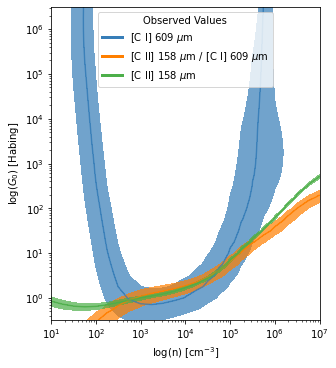

In [14]:
myunit = "erg s-1 cm-2 sr-1"
mx=Measurement(data=[1.5E-6],uncertainty = StdDevUncertainty(0.5E-6),identifier="CI_609",unit=myunit)
my=Measurement(data=[2],uncertainty = StdDevUncertainty(1),identifier="CII_158/CI_609",unit=myunit)
mz=Measurement(data=[3E-6],uncertainty = StdDevUncertainty(0.5E-6),identifier="CII_158",unit=myunit)
a=[mx,my,mz]
ids = [m.id for m in a]
d = dict(zip(ids,a))
print("dict:",d)
print(type(d["CI_609"]))
#d["CI_609"].levels
mp.overlay(a,shading=.71)
len(mx.data)
#q[1].id

In [17]:
mz.__dict__

{'_identifier': 'CII_158',
 '_title': None,
 '_restfreq': None,
 '_filename': None,
 '_defunit': 'adu',
 '_data': array([3.e-06]),
 '_mask': False,
 '_wcs': None,
 '_meta': OrderedDict([('BUNIT', 'erg s-1 cm-2 sr-1'),
              ('BMAJ', None),
              ('BMIN', None),
              ('BPA', None)]),
 '_unit': Unit("erg / (cm2 s sr)"),
 '_uncertainty': StdDevUncertainty([5.e-07]),
 '_flags': None}

In [ ]:
mp.plot("CI_609",image=True)#measurements=[mx],image=False,legend=True,contours=True,label=True)

In [ ]:
foo = np.array([1,2,3,4,5])*u.Unit("cm-3")
j = 10*np.ones(len(foo))
print(j)
z=np.power(j,foo.value)
foo = z*foo.unit
foo

In [ ]:
mp.plot("CI_609/FIR",image=True,measurements=[mx],legend=True,label=True)

In [ ]:
#mp.plot("CI_609/FIR",image=True,measurements=[mx,my],legend=True,yaxis_unit=u.erg/(u.second*u.cm*u.cm),label=False)

In [ ]:
l = LineRatioFit(m,[mx])

In [ ]:
p = LineRatioPlot(l)

In [ ]:
l.modelset.supported_ratios.show_in_notebook()

In [ ]:
p.modelintensity("CI_609",measurements=[mx],legend=True,xaxis_unit="m-3",contours=True,label=True)

In [ ]:
identifiers1 = ["OI_63+CII_158/FIR","OI_63/CII_158"]
identifiers2 = ["CO_21","OI_63"]
identifiers3 = ["CO_65","CI_609/CO_43"]

In [ ]:
mp.phaseplot(identifiers2,reciprocal=[False,False],dens_clip=[100,1E6]*u.Unit("cm-3"),rad_clip=[1,1E4]*utils._RFS_UNIT_)
mp.savefig("OI_CO21.png",bbox_inches='tight',facecolor='white')

In [ ]:
mp.phaseplot(identifiers1,reciprocal=[False,True],dens_clip=[100,1E6]*u.Unit("cm-3"),rad_clip=[10,1E6]*utils.habing_unit,)
mp.savefig("CII_OI_FIR.png",bbox_inches='tight',transparent=False,facecolor='white')

In [ ]:
mp.phaseplot(identifiers3,reciprocal=[False,False],dens_clip=[100,1E6]*u.Unit("cm-3"),rad_clip=[10,1E6]*utils.draine_unit)
mp.savefig("CI_CO.png",bbox_inches='tight',transparent=False,facecolor='white')

In [ ]:
models = [m.get_model(i) for i in identifiers]

In [ ]:
models[0].header["CUNIT2"]


In [ ]:
models[0].header.update(models[0].wcs.to_header())

In [ ]:
x,y=mp._get_xy_from_wcs(models[0],quantity=True)
print(x)
print(y)
#y._unit = utils.habing_unit

In [ ]:
#for i in np.arange(1,8):
#    print(i,np.squeeze(np.where(y==i)))
xi = [np.where(x==i)[0][0] for i in np.arange(1,8)]
yi = [np.where(y==i)[0][0] for i in np.arange(1,7)]

clip_low=yi[0]# clip below g=10
clip_high=yi[-1]+1 #clip above g=10^6
print(xi,yi,clip_low,clip_high)

In [ ]:
print(models[1].id,models[0].id)
models[1][4,6:]

In [ ]:
dens_clip=np.array([10,1E3])*u.Unit("cm-3")
rad_clip=[1,1.1E4]*utils._RFS_UNIT_
rad_clip=[10,1E4]*utils.habing_unit
reciprocal=[False,True]
from cycler import cycler
mp._plt.rc('axes', prop_cycle=(cycler('color',  mp._CB_color_cycle)))


xlog,ylog=mp._get_xy_from_wcs(models[0],quantity=True,linear=False)
xlin,ylin=mp._get_xy_from_wcs(models[0],quantity=True,linear=True)
#print("X,Y ",np.round(xlog,1),np.round(ylog,1))
#print("YHAB",y.to("Habing"))
dcc=dens_clip.to(xlog.unit)
rcc=rad_clip.to(ylog.unit)
#dc=[np.log10(dcc[0].value),np.log10(dcc[1].value)]*x.unit
#rc = [np.log10(rcc[0].value),np.log10(rcc[1].value)]*y.unit
#print("DC RC",dc,rc)
xi=np.where((xlin>=dcc[0]) & (xlin<=dcc[1]))[0]
yi=np.where((ylin>=rcc[0]) & (ylin<=rcc[1]))[0]
#print("XI,YI", xi,yi)
# can only get integer log steps in the original model units
# will have to label them with requested units at the end.
x2= np.hstack([np.where((np.round(xlog.value,1))==i)[0] for i in np.arange(-5,12)])
# for 2020 models Y is not an integral value in erg s-1 cm-2
y2 = np.hstack([np.where((np.round(ylog.value,1))==i)[0] for i in np.arange(-5,12)])
#print("xi,yi,x2,y2",xi,yi,x2,y2)
xi2=np.intersect1d(xi,x2)
yi2=np.intersect1d(yi,y2)
#print("XI2,YI2",xi2.flatten(),yi2.flatten())

linesN=[]
linesG=[]
for j in xi2:
    label=np.round(np.log10(xlin[j].to(dens_clip.unit).value),1)
    if reciprocal[0]:
        xx=1/models[1][yi2[0]:yi2[-1]+1,j]
    else:
        xx=models[1][yi2[0]:yi2[-1]+1,j]
        mp._plt.xlabel(models[1].title)
    if reciprocal[1]:
        yy=1/models[0][yi2[0]:yi2[-1]+1,j]
    else:
        yy=models[0][yi2[0]:yi2[-1]+1,j]
        mp._plt.ylabel(models[0].title)
    linesN.extend(mp._plt.loglog(xx,yy,label=label,lw=2))#,color='k'))

for j in yi2:
    label=np.round(np.log10(ylin[j].to(rad_clip.unit).value),1)
    if reciprocal[0]:
        xx=1/models[1][j,xi2[0]:xi2[-1]+1]
    else:
        xx=models[1][j,xi2[0]:xi2[-1]+1]
    if reciprocal[1]:
        yy=1/models[0][j,xi2[0]:xi2[-1]+1]
    else:
        yy=models[0][j,xi2[0]:xi2[-1]+1]
    linesG.extend(mp._plt.loglog(xx,yy,label=label,lw=2,ls='--'))
title1 = "log(n)"
unit1="["+dens_clip.unit.to_string("latex_inline")+"]" 
rs = rad_clip.unit.to_string()
rsl = rad_clip.unit.to_string("latex_inline")
title2 = "log("+utils.get_rad(rs)+")"
unit2="["+rsl+"]"
handles,labels=mp._plt.gca().get_legend_handles_labels()
phantom =  [mp._plt.plot([],marker="", markersize=0,ls="",lw=0)[0]]*2
#print("LENGTHS h %d g %d n %d"%(len(handles),len(linesG),len(linesN)))
lN = len(linesN)
lG = len(linesG)
diff = lN-lG
adiff=abs(diff)

phantom2 =[mp._plt.plot([],marker="", markersize=0,ls="",lw=0)[0]]*adiff
blank = ['']*adiff

if diff == 0:
    labels.insert(lN,unit2)
    labels.insert(lN,title2)
    labels = [title1,unit1]+labels
    linesN = phantom + linesN
    linesG = phantom + linesG
elif diff > 0:
    labels.insert(lN,unit2)
    labels.insert(lN,title2)
    labels = [title1,unit1]+labels
    linesN = phantom + linesN
    linesG = phantom + linesG
    labels = labels + blank
    linesG = linesG+phantom2
elif diff < 0:
    labels = labels[0:lN]+blank+labels[lN:]
    labels.insert(lN+adiff,unit2)
    labels.insert(lN+adiff,title2)
    labels = [title1,unit1]+labels
    linesN = phantom + linesN + phantom2
    linesG = phantom + linesG
handles = linesN+linesG
for kk in range(len(handles)):
    print(handles[kk],labels[kk])

#print(len(handles),len(labels))
leg=mp._plt.legend(handles,labels,ncol=2,markerfirst=True,bbox_to_anchor=(1.024,1))
leg._legend_box.align = "left"
for vpack in leg._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:2]:
        #print("C",hpack.get_children()[1].get_text())
        hpack.get_children()[0].set_width(0)
        #hpack.get_children()[1].set_offset((-3000000,10000))
ii = models[1].title.index('/')
print(models[1].title[ii+1:]+'/'+models[1].title[0:ii])

In [ ]:
zz=[1,2,3,4]
lll=int(np.size(zz)/2)
print(lll)
zz.insert(lll,'a')
zz[-1]

In [ ]:
mp._plt.imshow(models[1],origin='lower',cmap='plasma')

In [ ]:
print(models[1][26,6:22])
print(models[1][26,:])
print(np.flip(models[1][26,:])[6:22])

In [ ]:
#for i in np.arange(1,8):
#    print(i,np.squeeze(np.where(y==i)))
x,y=mp._get_xy_from_wcs(models[0],quantity=False,linear=False)
xi = [np.where(x==i)[0][0] for i in np.arange(1,8)]
yi = [np.where(y==i)[0][0] for i in np.arange(1,4)]

clip_low=yi[0]# clip below g=10
clip_high=yi[-1]+1 #clip above g=10^6
print(xi,yi,clip_low,clip_high)
xmin=models[1].data.min()
xmax=models[1].data.max()
ymin=models[0].data.min()
ymax=models[0].data.max()
print(xmin,xmax)
print(ymin,ymax)

fig,axes=mp._plt.subplots(ncols=2,nrows=1,figsize=(15,15))
print(type(axes[0]))

for a in axes:

    l=a.loglog(models[1][clip_low:clip_high,0],1/models[0][clip_low:clip_high,0],label='$n=10^1$',marker='+',lw=2)#,color='k')
    a.loglog(models[1][clip_low:clip_high,4],1/models[0][clip_low:clip_high,4],label='$n=10^2$',marker='+',lw=2)#,color='orange')
    a.loglog(models[1][clip_low:clip_high,8],1/models[0][clip_low:clip_high,8],label='$n=10^3$',marker='+',lw=2)#color='k')
    a.loglog(models[1][clip_low:clip_high,12],1/models[0][clip_low:clip_high,12],label='$n=10^4$',marker='+',lw=2)#,color='k')
    a.loglog(models[1][clip_low:clip_high,16],1/models[0][clip_low:clip_high,16],label='$n=10^5$',marker='+',lw=2)#,color='k')
    a.loglog(models[1][clip_low:clip_high,20],1/models[0][clip_low:clip_high,20],label='$n=10^6$',marker='+',lw=2)#,color='k')
    clip_low = clip_low-2
    a.loglog(np.flip(models[1][6])[clip_low:clip_high],np.flip(1/models[0][6])[clip_low:clip_high],label='$g=10^1$',ls=':',lw=2)#,color='orange')
    a.loglog(np.flip(models[1][10])[clip_low:clip_high],np.flip(1/models[0][10])[clip_low:clip_high],label='$g=10^2$',ls=':',lw=2)#color='k')
    a.loglog(np.flip(models[1][14])[clip_low:clip_high],np.flip(1/models[0][14])[clip_low:clip_high],label='$g=10^3$',ls=':',lw=2)#,color='k')
    a.loglog(np.flip(models[1][18])[clip_low:clip_high],np.flip(1/models[0][18])[clip_low:clip_high],label='$g=10^4$',ls=':',lw=2)#,color='k')
    a.loglog(np.flip(models[1][22])[clip_low:clip_high],np.flip(1/models[0][22])[clip_low:clip_high],label='$g=10^5$',ls=':',lw=2)#,color='k')
    a.loglog(np.flip(models[1][26])[clip_low:clip_high],np.flip(1/models[0][26])[clip_low:clip_high],label='$g=10^6$',ls=':',lw=2)#,color='k')
    a.set_xlim(5E-7,0.1)
    a.set_ylim(5e-3,15)
    a.set_aspect('equal')
    if False:
        a.legend(loc='best')
    else:
        print(a.get_lines())
        labelLines(a.get_lines()[0:4],zorder=2.5,align=False)
        labelLines(a.get_lines()[10:11],zorder=2.5,align=False)
  
    a.set_xlabel('OI+CII/FIR')
    a.set_ylabel('OI/CII')
#mp._plt.savefig("test.png",transparent=False)

In [ ]:
foo = 'x+yz'
ii = foo.index('/')
print(ii)